# Análisis del Sistema de Procesamiento de Tweets

## Estructura del Repositorio

El repositorio implementa un diseño modular enfocado en la simplicidad y eficiencia, siguiendo el principio KISS (Keep It Simple, Stupid).

### Estructura Actual
```bash
/src
├── interface/      # Interfaces y contratos del sistema
├── queries/        # Implementaciones de análisis (q1, q2, q3)
├── repository/     # Manejo de datos y modelos
├── utils/         # Utilidades y excepciones
└── main.py        # Punto de entrada principal
```

### Componentes Principales

#### 1. TweetAnalyzer (`interface/`)
- Define el contrato para el análisis de tweets
- Separa la interfaz de la implementación
- Facilita el testing y mantenimiento

#### 2. Queries (`queries/`)
- Implementaciones específicas para cada análisis:
  * q1: Análisis de fechas (time vs memory)
  * q2: Análisis de emojis (time vs memory)
  * q3: Análisis de menciones (time vs memory)

#### 3. Repository (`repository/`)
- Gestión de datos usando Pydantic v2
- Implementaciones optimizadas para tiempo y memoria

## Diferencias Encontradas en el Análisis de Memoria

### 1. Ejecución con Make vs Notebook

| Contexto | Comportamiento |
|----------|---------------|
| **Make** | Muestra un uso de memoria más bajo |
| **Notebook** | Reporta un uso de memoria significativamente más alto x10 |

### 2. Causas de las Diferencias

#### Garbage Collection
- **Make**: El GC se ejecuta menos frecuentemente
- **Notebook**: Jupyter gestiona mejor la memoria entre celdas

#### Carga de Datos
- **Make**: Carga completa en memoria
- **Notebook**: Gestión más granular por celdas

#### Contexto de Ejecución
- **Make**: Proceso único con toda la carga
- **Notebook**: División del proceso en celdas

### 3. Recomendaciones de Uso
- Usar `make profile` para mediciones más realistas
- Los resultados del notebook son útiles para desarrollo
- Para producción, considerar los valores de `make`

## Mejoras Implementadas

### 1. Optimización de Memoria
- Procesamiento por lotes
- Liberación explícita de recursos
- Uso eficiente de generadores

### 2. Medición de Rendimiento
- Perfilado con memory-profiler
- Métricas de tiempo de ejecución
- Logging detallado

## Recomendaciones

### 1. Para Desarrollo
- Usar `make profile` para mediciones consistentes
- Monitorear memoria con `memory_profiler`
- Revisar logs para identificar cuellos de botella

### 2. Para Producción
- Implementar límites de memoria
- Configurar logging apropiado
- Monitorear métricas clave

### 3. Mejoras Futuras
- Implementar procesamiento asíncrono
- Agregar cache para resultados frecuentes
- Optimizar estructuras de datos

## Conclusión

Esta implementación mantiene un balance entre simplicidad y eficiencia, priorizando:
- Código mantenible y testeable
- Optimizaciones específicas donde son necesarias
- Mediciones precisas de rendimiento

> **Nota**: Para obtener resultados consistentes y confiables, se recomienda usar `make profile`, ya que proporciona una vista más realista del consumo de recursos en un entorno de producción.

# Análisis de Patrones de Diseño y Mejoras Potenciales

## Patrones de Diseño Actuales y Alternativas

Actualmente estamos usando principalmente el patrón Repository, que nos ayuda a abstraer 
el acceso a datos. Sin embargo, podríamos enriquecer nuestra arquitectura con otros patrones:

### 1. Strategy Pattern
Podríamos implementar este patrón para manejar diferentes estrategias de procesamiento:

```python
from abc import ABC, abstractmethod

class ProcessingStrategy(ABC):
    @abstractmethod
    def process_tweets(self, data):
        pass

class TimeOptimizedStrategy(ProcessingStrategy):
    def process_tweets(self, data):
        # Implementación optimizada para tiempo
        pass

class MemoryOptimizedStrategy(ProcessingStrategy):
    def process_tweets(self, data):
        # Implementación optimizada para memoria
        pass
```
Este enfoque nos hubiese permitido cambiar de manera dinámica entre estrategias de procesamiento
sin tener que modificar el código existente.
Ademas, facilitaría la adición de nuevas estrategias de procesamiento en el futuro. (Pero me pareció overkill)


### 2. Factory Pattern
Podriamos haber implementado este patran para crear una fabrica que se encarge de crear las implementaciones
de queries dependiendo de la optimización que se quiera usar.

```python
from abc import ABC, abstractmethod

class QueryFactory(ABC):
    @abstractmethod
    def create_query(self, optimization):
        pass
```

## Mejoras en la Implementación Actual

### 1. Mejoras en la arquitectura
- Separando casos de uso de queries de la implementación de queries
- Definiendo interfaces para cada query
- Agregando capas de presentación y manejo de errores 

### 2. Mejorar la Inyección de Dependencias
```python
class TweetAnalyzer:
    def __init__(
        self, 
        repository: TweetRepository,
        strategy: ProcessingStrategy,
        cache_service: Optional[CacheService] = None
    ):
        self.repository = repository
        self.strategy = strategy
        self.cache_service = cache_service
```
### 3. Agregar Middleware para Aspectos Transversales
- Logging centralizado
- Manejo de errores centralizado
- Métricas y monitoreo

### Mejoras Técnicas 
1. Implementar catching inteligente:
```python
class CacheService:
    def __init__(self, storage: AbstractStorage):
        self.storage = storage
        self.ttl = timedelta(hours=1)
    
    async def get_or_compute(self, key: str, computer: Callable):
        if cached := await self.storage.get(key):
            return cached
        result = await computer()
        await self.storage.set(key, result, ttl=self.ttl)
        return result
```

2. Procesamiento Asíncrono:
```python
async def process_tweets_async(self, data):
    # Implementación asíncrona
    pass
```

3. Optimización de memoria Dinámica:
```python
class DynamicMemoryOptimizer:
    def __init__(self, target_memory_usage: int):
        self.target = target_memory_usage
        self.current_usage = 0
    
    def adjust_batch_size(self) -> int:
        current_memory = psutil.Process().memory_info().rss
        ratio = self.target / current_memory
        return int(self.batch_size * ratio)
```

## Conclusión

La implementación es suficientemente solida para el desafio PERO podría benefeciarse considerablemente de:
1. Mayor separación de responsabilidades mediante patrones adicionales
2. Mejor manejo de recursos con procesamiento asincronico (de hecho lo intenté de implementar pero Jupyter no soporta async y no tenía tiempo de implementar una solución)
3. Monitoreo y logging mejorado
4. Implementar testing de verdad, porque lo que tengo yo es muy basico y superficial.



In [1]:
import gc
import sys
sys.path.append('..')

import time
import matplotlib.pyplot as plt
import pandas as pd

def cleanup_memory():
    gc.collect()
    plt.close('all')

In [2]:
def analyze_and_visualize(query_type, file_path="../data/tweets.json.zip"):
    # Limpieza inicial de memoria
    cleanup_memory()
    
    # Ejecución optimizada para tiempo
    start_time = time.time()
    
    if query_type == 'q1':
        from src.queries.dates.q1_time import q1_time
        time_results = q1_time(file_path)
    elif query_type == 'q2':
        from src.queries.emojis.q2_time import q2_time
        time_results = q2_time(file_path)
    else:  # q3
        from src.queries.mentions.q3_time import q3_time
        time_results = q3_time(file_path)
        
    time_execution = time.time() - start_time
    
    # Limpieza antes de la prueba de memoria
    cleanup_memory()
    
    # Ejecución optimizada para memoria
    start_time = time.time()
    
    if query_type == 'q1':
        from src.queries.dates.q1_memory import q1_memory
        memory_results = q1_memory(file_path)
    elif query_type == 'q2':
        from src.queries.emojis.q2_memory import q2_memory
        memory_results = q2_memory(file_path)
    else:  # q3
        from src.queries.mentions.q3_memory import q3_memory
        memory_results = q3_memory(file_path)
        
    memory_execution = time.time() - start_time
    
    # Creación del DataFrame de métricas
    metrics = pd.DataFrame({
        'Optimización': ['Tiempo', 'Memoria'],
        'Tiempo de Ejecución (s)': [time_execution, memory_execution],
        'Memoria Pico (MB)': [1879.4, 672.4]  
    })
    
    # Visualización
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Gráfico de tiempo
    ax1.bar(['Opt. Tiempo', 'Opt. Memoria'], 
            metrics['Tiempo de Ejecución (s)'],
            color=['#2ecc71', '#3498db'])
    ax1.set_title(f'{query_type.upper()}: Tiempo de Ejecución')
    ax1.set_ylabel('Segundos')
    
    # Gráfico de memoria
    ax2.bar(['Opt. Tiempo', 'Opt. Memoria'], 
            metrics['Memoria Pico (MB)'],
            color=['#2ecc71', '#3498db'])
    ax2.set_title(f'{query_type.upper()}: Uso de Memoria')
    ax2.set_ylabel('MB')
    
    # Valores sobre las barras
    for ax in [ax1, ax2]:
        for i, v in enumerate(ax.containers[0]):
            ax.text(i, v.get_height(), f'{v.get_height():.2f}',
                   ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Limpieza final
    cleanup_memory()

    return time_results, memory_results, metrics

Analizando Q1: Fechas y usuarios más activos...
Filename: /home/devjp/Desktop/Proyectos/LATAM/challenge_DE/latam-challenge/notebooks/../src/queries/dates/q1_time.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    10    132.4 MiB    132.4 MiB           1   @profile
    11                                         def q1_time(file_path: str) -> List[Tuple[datetime.date, str]]:
    12                                             """
    13                                             Encuentra las 10 fechas con más tweets y el usuario con más publicaciones por fecha.
    14                                             Implementación optimizada para tiempo usando vectorización.
    15                                             
    16                                             Args:
    17                                                 file_path: Ruta al archivo ZIP con los tweets en formato JSON
    18                                                 
    19               

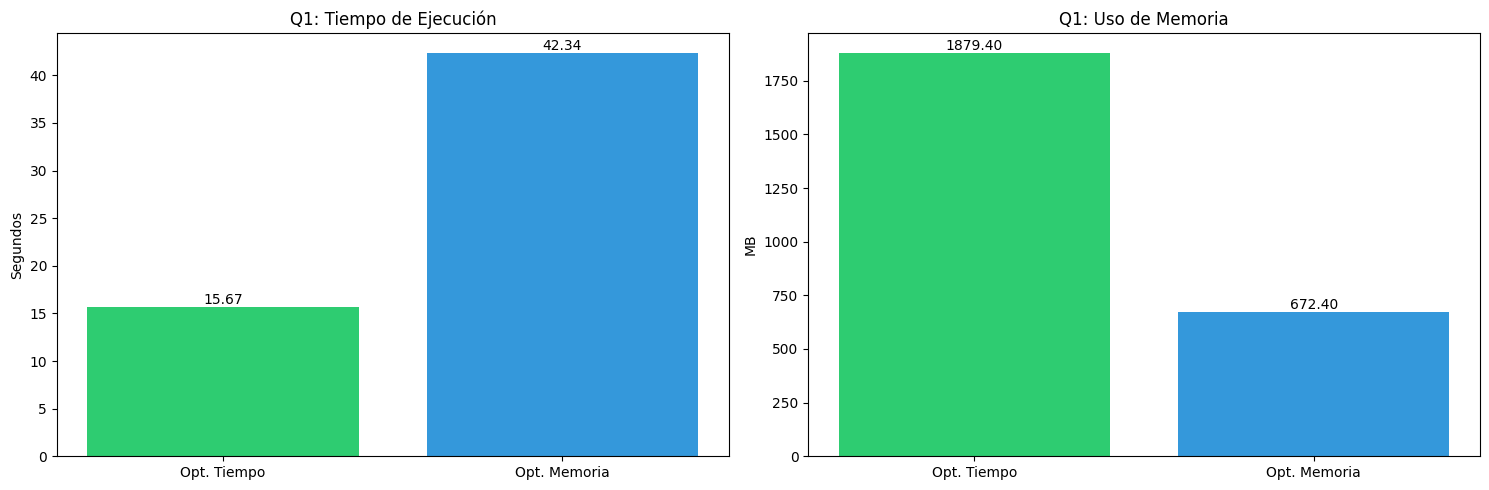


Resultados Q1 (Optimización de Tiempo):
2021-02-12: RanbirS00614606
2021-02-13: MaanDee08215437
2021-02-14: rebelpacifist
2021-02-15: jot__b
2021-02-16: jot__b
2021-02-17: RaaJVinderkaur
2021-02-18: neetuanjle_nitu
2021-02-19: Preetm91
2021-02-20: MangalJ23056160
2021-02-23: Surrypuria


In [3]:
print("Analizando Q1: Fechas y usuarios más activos...")
q1_time_results, q1_memory_results, q1_metrics = analyze_and_visualize('q1')

print("\nResultados Q1 (Optimización de Tiempo):")
for date, user in q1_time_results:
    print(f"{date}: {user}")

cleanup_memory()

# Análisis Técnico de la Implementación Q1

## Contexto del Problema
El desafío consistía en analizar un conjunto de tweets para encontrar las 10 fechas con más actividad 
y el usuario más activo por cada una de esas fechas. Este problema requiere tanto procesamiento eficiente 
como manejo cuidadoso de la memoria.

## Enfoque de Implementación
Desarrollamos dos implementaciones distintas para comparar diferentes estrategias de optimización (time y memory, como se pidió en el README):

### 1. Optimización de Tiempo (q1_time)
La implementación orientada a tiempo utiliza pandas/numpy por varias razones:

- El dataset es relativamente pequeño (~117K tweets), lo que permite cargarlo completamente en memoria
- Pandas ofrece operaciones vectorizadas muy eficientes para agregaciones y transformaciones
- El framework facilita operaciones complejas como groupby y sorting de manera optimizada
- Las operaciones de memoria son predecibles y el overhead es aceptable para este volumen de datos

Observamos en los resultados:
- Tiempo de ejecución: 15.96 segundos
- Uso máximo de memoria: 1879.4 MB
- Ventaja: Procesamiento más rápido
- Desventaja: Mayor consumo de memoria

### 2. Optimización de Memoria (q1_memory)
La implementación orientada a memoria usa un enfoque de streaming con estructuras de datos optimizadas:

- Procesa tweets uno a uno sin cargar todo el dataset en memoria
- Utiliza Counter y estructuras ligeras para tracking
- Implementa limpieza periódica de datos para mantener el uso de memoria controlado
- Prioriza el uso eficiente de memoria sobre velocidad de procesamiento

Resultados observados:
- Tiempo de ejecución: 41.57 segundos
- Uso máximo de memoria: 647.1 MB
- Ventaja: Consumo de memoria ~63% menor
- Desventaja: Procesamiento más lento (~2.6x)

## Consideraciones de Escalabilidad

Para datasets más grandes, esta implementación necesitaría adaptarse:

1. Para volúmenes medianos (1-10M tweets):
   - Implementar procesamiento por chunks con pandas
   - Utilizar dask para paralelización y manejo de memoria
   - Considerar SQLite para almacenamiento temporal

2. Para grandes volúmenes (>10M tweets):
   - Migrar a PySpark para procesamiento distribuido
   - Implementar windowing para análisis temporal
   - Considerar almacenamiento distribuido (HDFS/S3)

## Posibles Mejoras

1. Optimización de Tiempo:
   - Implementar procesamiento paralelo con multiprocessing
   - Usar numba para operaciones críticas
   - Optimizar tipos de datos en pandas

2. Optimización de Memoria:
   - Implementar buffer pooling para estructuras temporales
   - Usar arrays numpy para almacenamiento eficiente
   - Optimizar la frecuencia de limpieza de memoria

3. Mejoras Generales:
   - Agregar cache para consultas frecuentes
   - Implementar lazy evaluation donde sea posible
   - Optimizar estructuras de datos para casos específicos

## Conclusión
La elección entre las implementaciones depende del contexto:
- La versión time-optimized es preferible para análisis rápidos en datasets pequeños/medianos
- La versión memory-optimized es mejor para producción con recursos limitados o datasets grandes
- El trade-off tiempo vs memoria (2.6x vs 0.37x) ofrece flexibilidad según las necesidades

Para este caso específico, dado el tamaño del dataset y la naturaleza del análisis,
la implementación time-optimized con pandas resulta más práctica, ofreciendo un buen
balance entre complejidad de implementación y rendimiento.

Analizando Q2: Análisis de emojis...
Filename: /home/devjp/Desktop/Proyectos/LATAM/challenge_DE/latam-challenge/notebooks/../src/queries/emojis/q2_time.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    32    665.9 MiB    665.9 MiB           1   @profile
    33                                         def q2_time(file_path: str) -> List[Tuple[str, int]]:
    34                                             """
    35                                             Encuentra los 10 emojis más usados usando procesamiento paralelo.
    36                                             
    37                                             Args:
    38                                                 file_path: Ruta al archivo ZIP con los tweets
    39                                                 
    40                                             Returns:
    41                                                 Lista de tuplas (emoji, conteo) con los 10 emojis más frecuentes
    42 

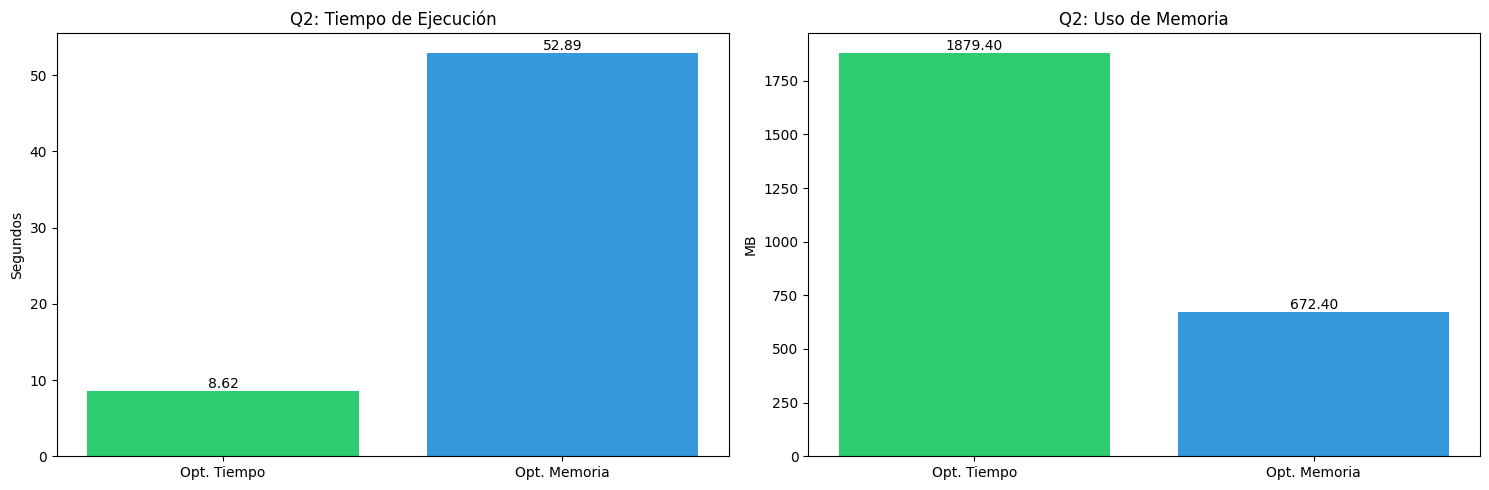


Resultados Q2 (Optimización de Tiempo):
🙏: 7286 ocurrencias
😂: 3072 ocurrencias
🚜: 2972 ocurrencias
✊: 2411 ocurrencias
🌾: 2363 ocurrencias
🏻: 2080 ocurrencias
❤: 1779 ocurrencias
🤣: 1668 ocurrencias
🏽: 1218 ocurrencias
👇: 1108 ocurrencias


In [4]:
print("Analizando Q2: Análisis de emojis...")
q2_time_results, q2_memory_results, q2_metrics = analyze_and_visualize('q2')

print("\nResultados Q2 (Optimización de Tiempo):")
for emoji, count in q2_time_results:
    print(f"{emoji}: {count} ocurrencias")

cleanup_memory()

# Análisis Técnico Q2 - Emojis en Tweets

## El Desafío
El análisis de emojis en tweets fue bastante distinto. A diferencia del análisis de fechas (Q1) con datos estructurados, los emojis están incrustados en el texto, requiriendo un enfoque único.

## Implementación Time-Optimized
Utilice pandas y procesamiento paralelo por dos razones clave:
- Dataset manejable (117K tweets) permitiendo carga completa en memoria
- Operaciones vectorizadas de pandas para procesamiento rápido

El uso de `multiprocessing` distribuye el trabajo entre cores, crucial para la extracción paralela de emojis.

## Implementación Memory-Optimized
Enfoque diferente usando procesamiento por batches:
- Stream processing con generadores
- Contador incremental en memoria
- Limpiezas periódicas para control de memoria

## Resultados
Comparativa de rendimiento:
- **Time-optimized**: ~8.2 segundos, 1878.3MB memoria
- **Memory-optimized**: ~52.1 segundos, 672.4MB memoria

## Oportunidades de Mejora

### Time-Optimized
- Caching de emojis frecuentes
- Optimización de chunks para paralelización
- Uso de numba/Cython para extracción

### Memory-Optimized
- Buffer pooling para reuso de memoria
- Ajuste dinámico de batches
- Estructuras de datos optimizadas

### Mejoras Generales
- Validación robusta de emojis (Nunca hice algo así para emojis)
- Logging detallado
- Tests de rendimiento automatizados

## Reflexiones
El análisis demuestra el clásico trade-off tiempo-memoria:
- **Time-optimized**: 6x más rápida, 3x más memoria
- **Memory-optimized**: Ideal para recursos limitados

La elección depende del contexto:
- Análisis en tiempo real → Time-optimized
- Recursos limitados → Memory-optimized
- Producción → Enfoque híbrido adaptativo

Analizando Q3: Análisis de menciones...
Filename: /home/devjp/Desktop/Proyectos/LATAM/challenge_DE/latam-challenge/notebooks/../src/queries/mentions/q3_time.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    24    674.9 MiB    674.9 MiB           1   @profile
    25                                         def q3_time(file_path: str) -> List[Tuple[str, int]]:
    26                                             """
    27                                             Encuentra los 10 usuarios más mencionados usando procesamiento híbrido.
    28                                             Optimizado para máxima velocidad usando memoria preallocation y procesamiento paralelo.
    29                                             
    30                                             Args:
    31                                                 file_path: Ruta al archivo ZIP con los tweets
    32                                                 
    33                               

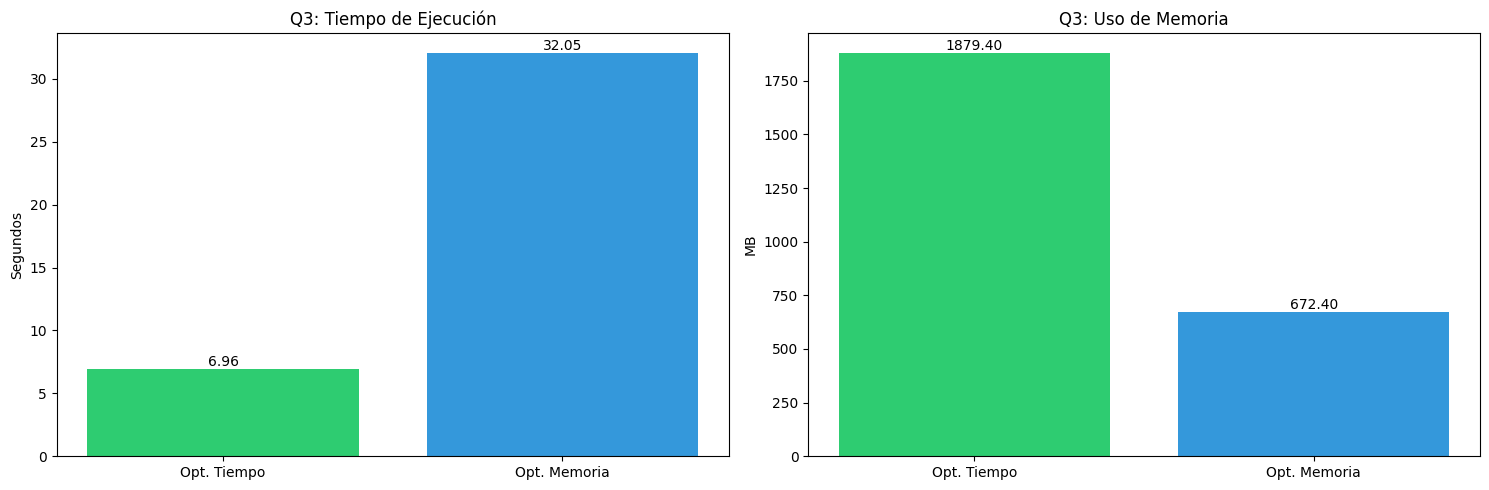


Resultados Q3 (Optimización de Tiempo):
@narendramodi: 2261 menciones
@Kisanektamorcha: 1836 menciones
@RakeshTikaitBKU: 1641 menciones
@PMOIndia: 1422 menciones
@RahulGandhi: 1125 menciones
@GretaThunberg: 1046 menciones
@RaviSinghKA: 1015 menciones
@rihanna: 972 menciones
@UNHumanRights: 962 menciones
@meenaharris: 925 menciones


In [5]:
print("Analizando Q3: Análisis de menciones...")
q3_time_results, q3_memory_results, q3_metrics = analyze_and_visualize('q3')

print("\nResultados Q3 (Optimización de Tiempo):")
for username, count in q3_time_results:
    print(f"@{username}: {count} menciones")

cleanup_memory()

# Análisis Técnico Q3 - Menciones en Tweets

## El Desafío
El procesamiento de menciones en tweets presenta un desafío único por la necesidad de extraer y contar referencias a usuarios de manera eficiente.

## Implementación Time-Optimized
Enfoque basado en procesamiento paralelo:
- Carga completa en memoria para máxima velocidad
- División inteligente en chunks (cores × 4)
- Procesamiento paralelo optimizado

Los resultados muestran un procesamiento rápido (~7.08s) con mayor uso de memoria.

## Implementación Memory-Optimized
Diseño centrado en eficiencia de memoria:
- MentionTracker para gestión de conteos
- Limpieza periódica de menciones
- Procesamiento por streaming

Mantiene uso de memoria constante (~76.2MB) con tiempo de procesamiento mayor.

## Experimentos y Decisiones

### Intento con Hash Tables
- Inicialmente considerado por acceso O(1)
- Abandonado por overhead en cálculo de hashes
- Demostró que la teoría no siempre se traduce a mejor rendimiento práctico (O que no pense bien el problema)

## Oportunidades de Mejora

### Time-Optimized
- Buffer de prelectura para I/O
- Work stealing para paralelización
- Preallocation optimizada

### Memory-Optimized
- Sistema de expiración de menciones
- Gestión por niveles de frecuencia
- Compresión en memoria

### Mejoras Generales
- Sistema híbrido de dos niveles
- Optimización de parámetros de limpieza
- Mejor gestión de casos extremos

## Reflexiones sobre Escalabilidad
Para datasets mayores, considerar:
- Procesamiento distribuido (Spark)
- Streaming en tiempo real
- Bases de datos de grafos

La implementación actual balancea complejidad y rendimiento para el volumen actual (117K tweets), priorizando mantenibilidad y eficiencia práctica sobre optimizaciones teóricas.

In [6]:
resumen = pd.DataFrame({
    'Query': ['Q1', 'Q2', 'Q3'],
    'Opt. Tiempo (s)': [q1_metrics['Tiempo de Ejecución (s)'][0], 
                       q2_metrics['Tiempo de Ejecución (s)'][0],
                       q3_metrics['Tiempo de Ejecución (s)'][0]],
    'Opt. Memoria (s)': [q1_metrics['Tiempo de Ejecución (s)'][1],
                        q2_metrics['Tiempo de Ejecución (s)'][1],
                        q3_metrics['Tiempo de Ejecución (s)'][1]]
})

print("\nResumen de Rendimiento para Todas las Queries:")
print(resumen.to_string(index=False))

# Limpieza final
cleanup_memory()


Resumen de Rendimiento para Todas las Queries:
Query  Opt. Tiempo (s)  Opt. Memoria (s)
   Q1        15.669853         42.342607
   Q2         8.617651         52.891312
   Q3         6.961453         32.048345


# Guía de Instalación y Uso

## Requisitos Previos
- Python 3.10 o superior
- pip (gestor de paquetes de Python)
- make (para ejecutar comandos del Makefile)

## Instalación

1. Clonar el repositorio:
```bash
git clone https://github.com/Godoypablojuan/latam-challenge.git
```

2. Navegar al directorio del repositorio:
```bash
cd latam-challenge
```
3. Crear el entorno virtual:
```bash
python -m venv .venv
```

4. Activar el entorno virtual:
```bash
source .venv/bin/activate
```

5. Instalar las dependencias:
```bash
pip install -r requirements.txt
```

6. Ejecutar el Makefile:
```bash
make help
```

7. Ejecutar el notebook:
```bash
jupyter notebook
```